# Лабораторная работа №6: Кластеризация

*Данные*: load_breast_cancer

### Импорт пакетов

In [112]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import silhouette_samples
from sklearn.metrics import accuracy_score
from matplotlib import cm 
from matplotlib import pyplot as plt
import seaborn as sns

palette = sns.color_palette("hls", 8)
sns.set_theme(palette=palette)

### Загрузка данных
Исходные данные содержат 569 наблюдений и 30 параметров

Для рассматрения возьмём средние значения 3-ёх признаков ядра клетки:
* **Perimeter** - периметр
* **Smoothness** - гладкость
* **Area** - площадь

Задача состоит в разделении клеток на группы в зависимости от этих показателей

In [113]:
data = load_breast_cancer()
Df = pd.DataFrame(data.data, columns=data.feature_names)
Df = Df[["mean perimeter", "mean smoothness", "mean area"]]
Df.columns = ["perimeter", "smoothness", "area"]
Df

,perimeter,smoothness,area
0,122.80,0.11840,1001.0
1,132.90,0.08474,1326.0
2,130.00,0.10960,1203.0
3,77.58,0.14250,386.1
4,135.10,0.10030,1297.0
...,...,...,...
564,142.00,0.11100,1479.0
565,131.20,0.09780,1261.0
566,108.30,0.08455,858.1
567,140.10,0.11780,1265.0


Стандартизация данных

In [114]:
scaler = StandardScaler()
df = scaler.fit_transform(Df)
df = pd.DataFrame(df, columns=Df.columns)
df_2 = df[["perimeter", "smoothness"]]
df

,perimeter,smoothness,area
0,1.269934,1.568466,0.984375
1,1.685955,-0.826962,1.908708
2,1.566503,0.942210,1.558884
3,-0.592687,3.283553,-0.764464
4,1.776573,0.280372,1.826229
...,...,...,...
564,2.060786,1.041842,2.343856
565,1.615931,0.102458,1.723842
566,0.672676,-0.840484,0.577953
567,1.982524,1.525767,1.735218


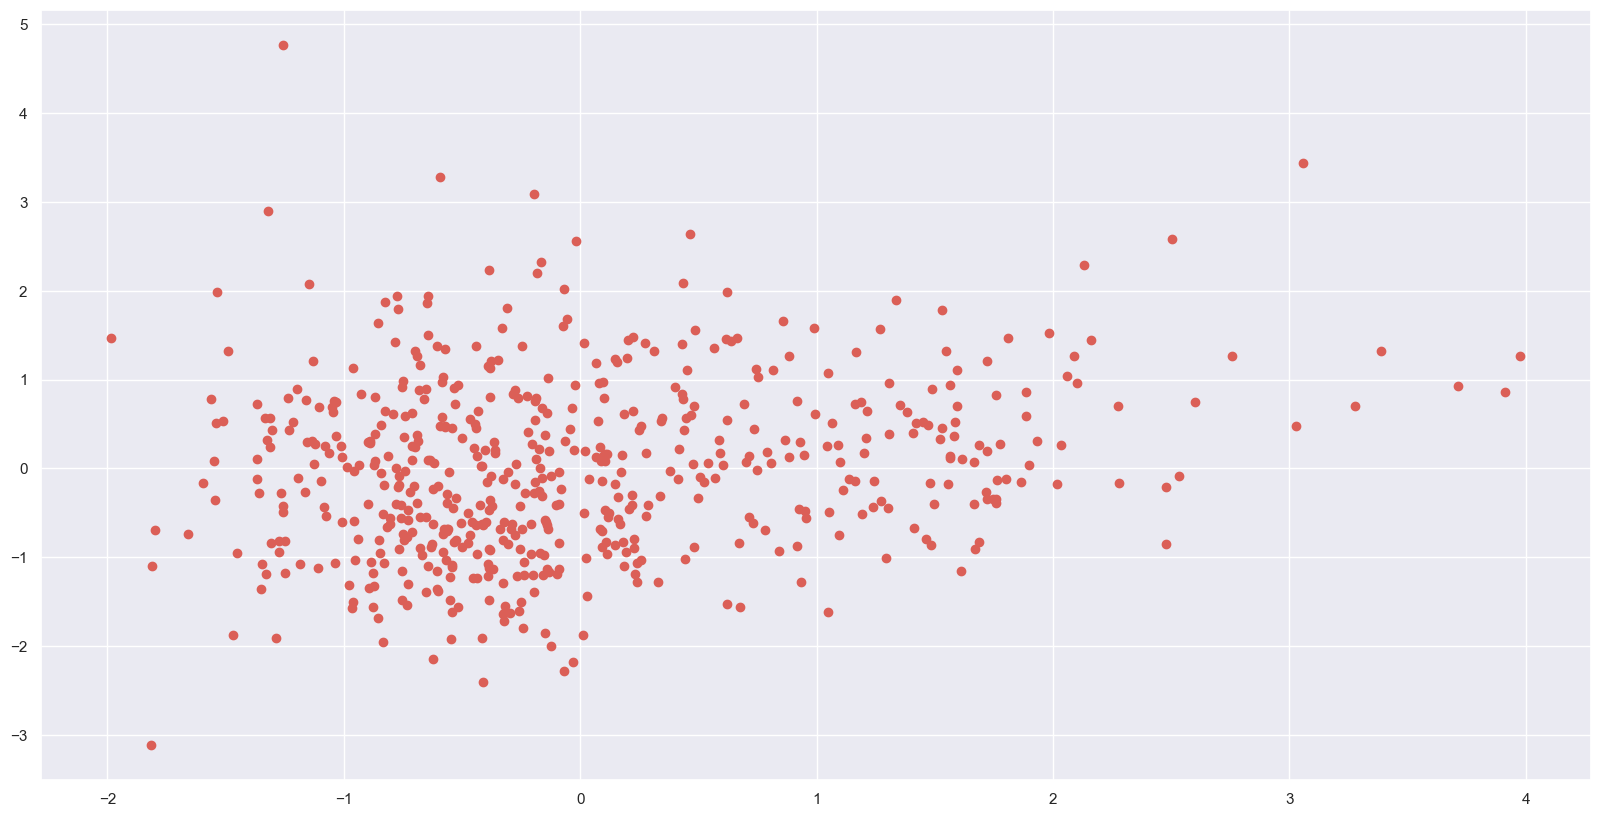

In [115]:
plt.figure(figsize=(20,10))
plt.scatter(df.perimeter, df.smoothness)
plt.show()

Визуально данные тяжело сгруппировать на отдельные кластеры. Но можно взять, допустим, 2 группы

### Определение оптимального количества кластеров методом локтя

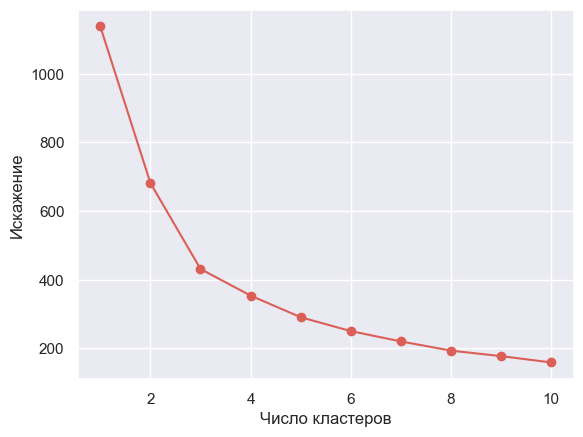

In [116]:
distortions = [] 
for i in range (1, 11): 
    km = KMeans(n_clusters=i, 
                init='random', 
                n_init=10 , 
                max_iter=300, 
                random_state=0) 
    km.fit(df_2)
    distortions.append(km.inertia_) 
plt.plot(range(1, 11) , distortions , marker='o') 
plt.xlabel('Чиcлo кластеров') 
plt.ylabel('Искажение') 
plt.show()

Как видно на графике выше, локоть расположен в k равным 3, что свидетельствует о том, что это значение является хорошим выбором для этого набора данных

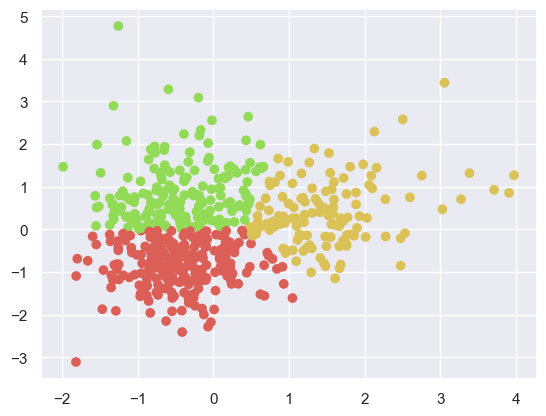

In [117]:
kmeans = KMeans(n_clusters=3,random_state=0).fit(df_2.values)
colors = [palette[i] for i in kmeans.labels_]
plt.scatter(df.perimeter, df.smoothness, c=colors)
plt.show()

С помощью визуального анализа скорее можно сказать про 2 различные группы. Сделаем такое построение:

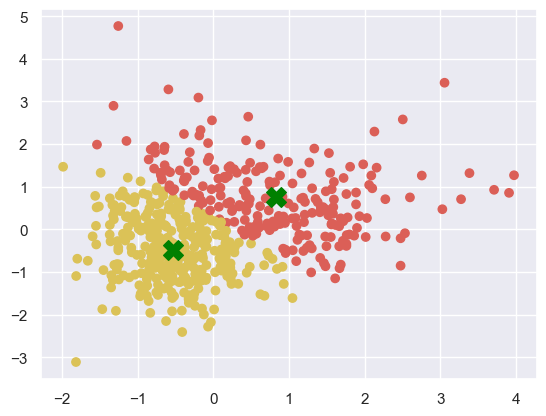

In [118]:
kmeans = KMeans(n_clusters=2,random_state=0).fit(df_2.values)
colors = [palette[i] for i in kmeans.labels_]
plt.scatter(df.perimeter, df.smoothness, c=colors)
plt.scatter(kmeans.cluster_centers_ [:, 0], kmeans.cluster_centers_ [:, 1], 
           s=200, marker= 'X', c = 'green', label = 'центроиды')
plt.show()

Теперь видим, что каждая группа точек покрашена в цвет соответствующего кластера, а центроиды расположены внутри множества точек. Тем не менее, попробуем оценить качество кластеризации в обоих вариантах.

### Количественная оценка качества кластеризации

Средний коэффициент силуэта --  0.39280429356026775


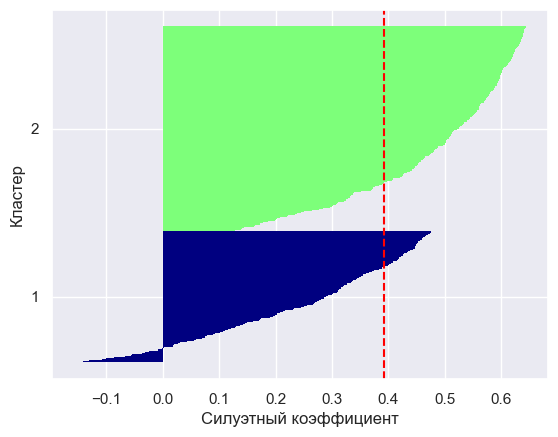

In [119]:
kmeans = KMeans(n_clusters=2,random_state=0).fit(df_2.values)
y_km = kmeans.fit_predict(df_2) 

cluster_labels = np.unique(y_km) 
n_clusters = cluster_labels.shape[0] 
silhouette_vals = silhouette_samples(df_2, y_km, metric='euclidean')

y_ax_lower , y_ax_upper = 0, 0 
yticks = [] 
for i, c in enumerate(cluster_labels): 
    c_silhouette_vals = silhouette_vals[y_km == c] 
    c_silhouette_vals.sort() 
    y_ax_upper += len(c_silhouette_vals) 
    color = cm.jet(float(i) / n_clusters) 
    plt.barh(range(y_ax_lower, y_ax_upper), 
             c_silhouette_vals , 
             height=1.0, 
             edgecolor='none', 
             color=color) 
    yticks.append((y_ax_lower + y_ax_upper) / 2) 
    y_ax_lower += len(c_silhouette_vals) 
silhouette_avg = np.mean(silhouette_vals) 
    
plt.axvline(silhouette_avg, color= "red", linestyle="--" ) 
print ("Средний коэффициент силуэта -- ", silhouette_avg)
plt.yticks(yticks, cluster_labels + 1) 
plt.ylabel ('Кластер') 
plt.xlabel('Силуэтный коэффициент') 
plt.show() 

In [120]:
kmeans = KMeans(n_clusters=3,random_state=0).fit(df_2.values)
y_km = kmeans.fit_predict(df_2) 

silhouette_vals = silhouette_samples(df_2, y_km, metric='euclidean')
silhouette_avg = np.mean(silhouette_vals) 

print ("Средний коэффициент силуэта -- ", silhouette_avg)

Средний коэффициент силуэта --  0.4091072731038419


Его значение незначительно выше, чем в предыдущем случае. Но формально $k=2$ - единственное разбиение, так как раковые клетки могут быть только доброкачественные и злокачественные


### Сравнение результатов на обучающей и тестовой выборке
Посмотрим, как прогнозировать принадлежность к кластерам, построенным по обучающим данным. Сравним значения средних силуэтных коэффициентов.

В обучающей выборке - 80% исходных наблюдений.

In [121]:
df_train = df.sample(frac=0.8)

# данные для прогнозов
df_predict = df.drop(df_train.index)

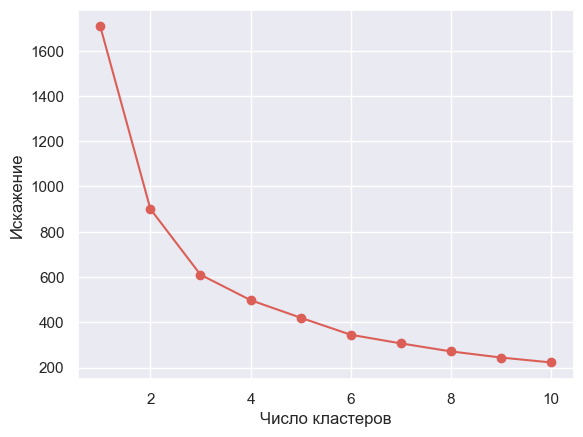

In [122]:
distortions = [] 
for i in range (1, 11): 
    km = KMeans(n_clusters=i, 
                init='random', 
                n_init=10 , 
                max_iter=300, 
                random_state=0) 
    km.fit(df)
    distortions.append(km.inertia_) 
plt.plot(range(1, 11) , distortions , marker='o') 
plt.xlabel('Чиcлo кластеров') 
plt.ylabel('Искажение') 
plt.show()

Перелом сместился ближе к 2 значению

Обучаем алгоритм и считаем средний силуэтный коэффициент.

In [123]:
kmeans = KMeans(n_clusters=2,random_state=0).fit(df_train.values)
y_km_train = kmeans.fit_predict(df_train) 
silhouette_vals = silhouette_samples(df_train, y_km_train, metric='euclidean')
silhouette_avg = np.mean(silhouette_vals) 
print ("Средний коэффициент силуэта -- ", silhouette_avg)

Средний коэффициент силуэта --  0.46175902196471225


Применяем модель к новым данным. Значение среднего силуэтного коэффициента  улучшилось.

In [124]:
y_km_predict = kmeans.fit_predict(df_predict) 
silhouette_vals = silhouette_samples(df_predict, y_km_predict, metric='euclidean')
silhouette_avg = np.mean(silhouette_vals) 
print ("Средний коэффициент силуэта -- ", silhouette_avg)

Средний коэффициент силуэта --  0.5271117328493885


### Статистический анализ получившихся кластеров

In [125]:
kmeans = KMeans(n_clusters=2,random_state=0).fit(df.values)
df["KM"] = kmeans.fit_predict(df) 

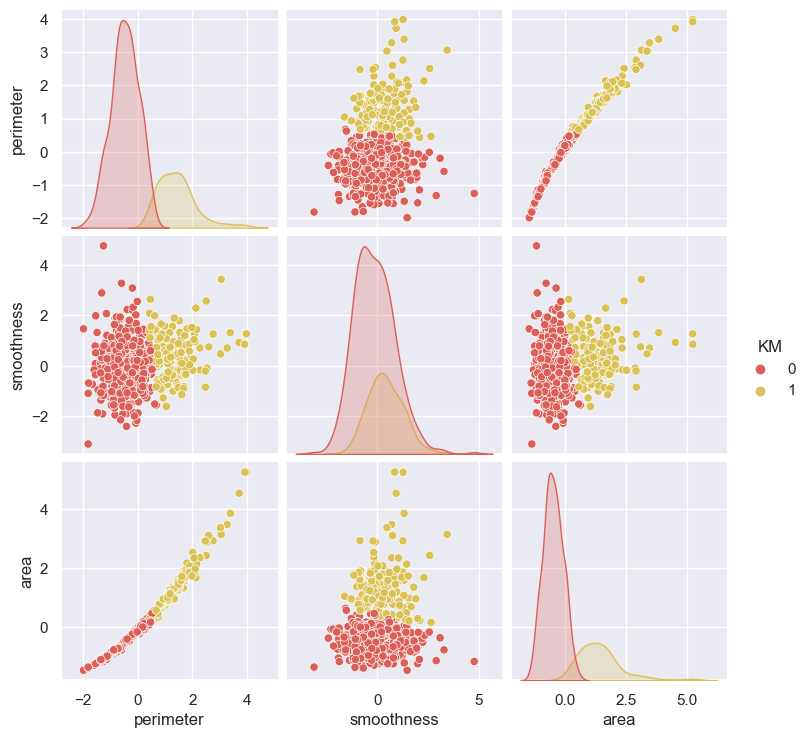

In [126]:
sns.pairplot(df, hue='KM')
plt.show()

### Оценка точности

Для двух параметров

In [127]:
labels_true = data.target

kmeans = KMeans(n_clusters=2, random_state=0).fit(df_2)
labels_pred = kmeans.labels_

acc = accuracy_score(labels_true, labels_pred)

print(acc)

0.8558875219683656


Для трёх параметров

In [130]:
labels_true = data.target

kmeans = KMeans(n_clusters=2, random_state=0).fit(df)
labels_pred = kmeans.labels_

acc = accuracy_score(labels_true, labels_pred)

print(acc)

0.1335676625659051


Можно сказать, что с точностью 85.6% два параметра perimeter и smoothness корректно определяют принадлежность к доброкачественной или злокачественной группе